In [252]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

from multiprocessing.pool import ThreadPool, Pool
import threading
from tqdm import tqdm
import csv

import os

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import datetime

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

In [253]:
season = 8
root_folder = './challenger_datas/'

In [254]:
for (dirpath, dirnames, filenames) in os.walk(root_folder):
    print(filenames)

['S7-2023-01-10.csv', 'S8-2023-01-17.csv']


In [255]:
#file_name = 'S%d-%s.csv' % (season, datetime.date.today())
file_name = 'S7-2023-01-10.csv'

file_path = os.path.join(root_folder, file_name)

In [256]:
if not os.path.exists(file_path):
    threadLocal = threading.local()

    response = requests.get(
    "https://sea.wildstats.gg/en/leaderboard")
    soup = BeautifulSoup(response.text, "html.parser")
    elements = soup.findAll('a', attrs = {'class' : 'text-truncate'})
    leaderboard = [
        (
            'https://sea.wildstats.gg'+element.attrs["href"], 
            element.findChildren("span")[0].text
        ) for element in elements
    ]

    print('total datas number:', len(leaderboard))
    print('top 5 players:')
    print(leaderboard[:5])

    def get_driver():
        driver = getattr(threadLocal, 'driver', None)
        if driver is None:
            chrome_options = Options()
            chrome_options.add_argument("--headless")
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), 
                                        options=chrome_options)

            setattr(threadLocal, 'driver', driver)
        return driver

    def scrap(data):
        url, id = data

        driver = get_driver()

        driver.get(url)
        html = driver.page_source
        soup = BeautifulSoup(html, features="html.parser")
        row_datas = soup.findAll('h1', attrs={'class': 'text-center m-0'})

        row_datas_text = [data.text for data in row_datas]
        marks = soup.find('span', attrs={'class':'badge badge-overlay text-white'}).findAll('div')[1].text.strip()
        return (marks, *row_datas_text, url)

    with ThreadPool(5) as p:
        challenger_datas = list(tqdm(p.imap(scrap, leaderboard), total=len(leaderboard)))
    driver = get_driver()
    driver.quit()

    df = pd.DataFrame(challenger_datas, columns=['Marks', 'WinRate', 'MVP', 'Played', 'URL'])

    df.to_csv(file_path, index=False)
else:
    df = pd.read_csv(file_path)

In [257]:
print(df.head())

   Marks WinRate  MVP Played  \
0    244  58.53%  341  1,102   
1    234  62.05%  330    751   
2    221  64.34%  265    603   
3    214  61.81%  234    741   
4    200  59.08%  307    782   

                                                 URL  
0  https://sea.wildstats.gg/en/profile/D1pWIYi6Y5...  
1  https://sea.wildstats.gg/en/profile/S4oFFBRE88...  
2  https://sea.wildstats.gg/en/profile/6LYjywZ3n8...  
3  https://sea.wildstats.gg/en/profile/EROGPRmlwy...  
4  https://sea.wildstats.gg/en/profile/YwMfAm4can...  


In [258]:
df['Marks'] = df['Marks'].astype('int')
df['WinRate'] = df['WinRate'].str.rstrip('%').astype('float')
df['MVP'] = df['MVP'].astype('int') 
df['Played'] = df['Played'].astype('str').str.replace(',', '').astype('int')

```
df['Marks']
df['WinRate']
df['MVP'] / df['Played']
```

In [259]:
def plot_3d_in_2d(x, y, z, x_label, y_label, z_label, title, save_name):
    fig, ax = plt.subplots()

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    x_gap = (x.max() - x.min()) / 10
    y_gap = (y.max() - y.min()) / 10

    ax.set_xlim((x.min()-x_gap, x.max()+3*x_gap))
    ax.set_ylim((y.min()-y_gap, y.max()+3*y_gap))

    color = z
    cmap = plt.get_cmap('Spectral')
    norm = plt.Normalize(vmin=z.min(), vmax=z.max())

    plt.scatter(x, y, cmap=cmap, norm=norm, c=color, alpha=0.35) 
    fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=z_label)

    plt.text(x=0.5, y=0.95, 
             s='PPMCC: '+str(round(np.corrcoef(x, y)[0, 1], 4)), 
             horizontalalignment='center',
             verticalalignment='center', 
             transform=ax.transAxes)

    plt.tight_layout()
    # TODO: title is cutted when saving as png
    # TODO: rearrange folder structure
    # TODO: subplot 1, 2, 3, 4
    #plt.subplots_adjust(top=0.85)
    plt.savefig(save_name)
    plt.title(title)

    plt.show()

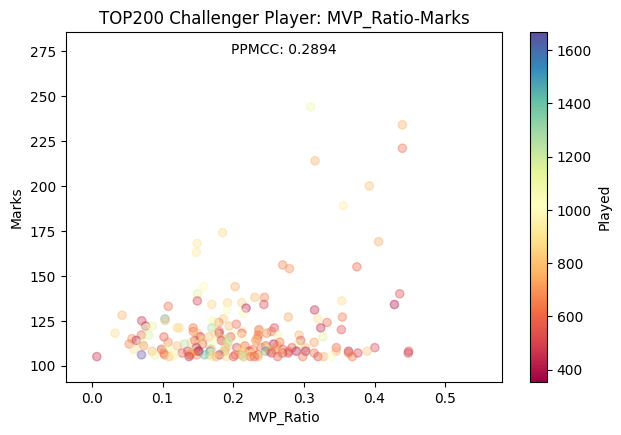

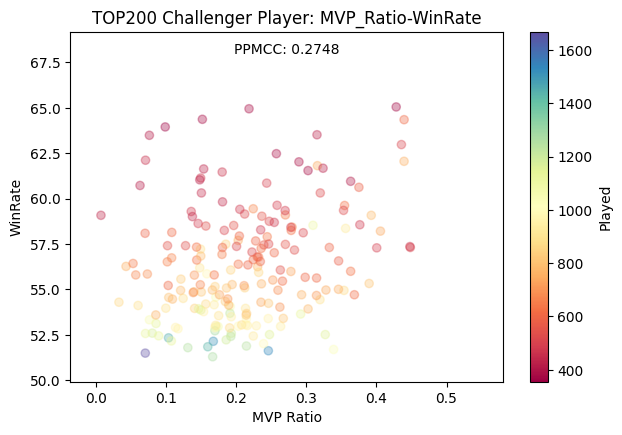

In [260]:
file_name_pure = os.path.splitext(file_name)[0]

plot_3d_in_2d(x=df['MVP'] / df['Played'], 
              y=df['Marks'], 
              z=df['Played'],
              x_label='MVP_Ratio', y_label='Marks', z_label='Played',
              title='TOP200 Challenger Player: MVP_Ratio-Marks',
              save_name=file_name_pure+'(1).png')
plot_3d_in_2d(x=df['MVP'] / df['Played'], 
              y=df['WinRate'], 
              z=df['Played'],
              x_label='MVP Ratio', y_label='WinRate', z_label='Played',
              title='TOP200 Challenger Player: MVP_Ratio-WinRate',
              save_name=file_name_pure+'(2).png')


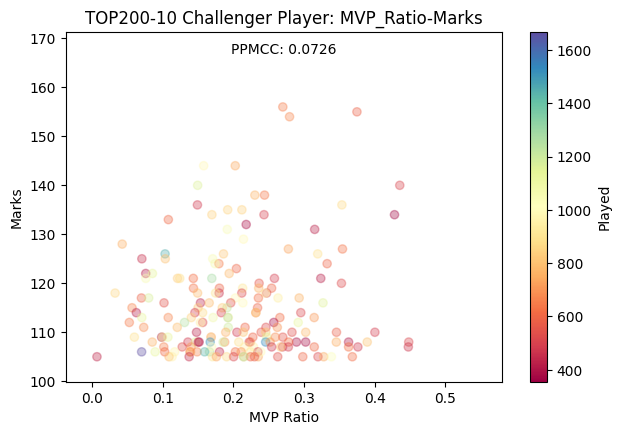

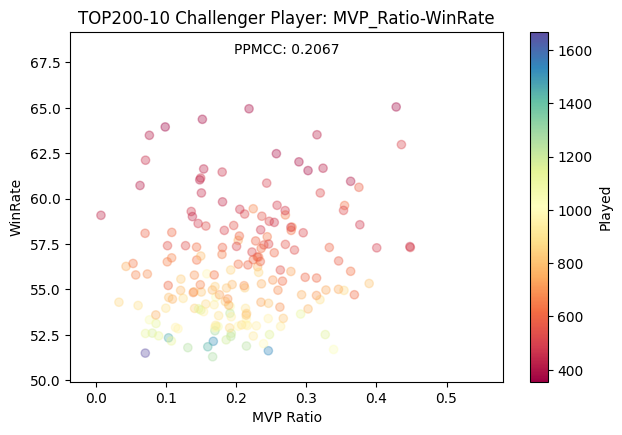

In [261]:
ndf = df.iloc[10:]

plot_3d_in_2d(x=ndf['MVP'] / ndf['Played'], 
              y=ndf['Marks'], 
              z=ndf['Played'],
              x_label='MVP Ratio', y_label='Marks', z_label='Played',
              title='TOP200-10 Challenger Player: MVP_Ratio-Marks',
              save_name=file_name_pure+'(3).png')
plot_3d_in_2d(x=ndf['MVP'] / ndf['Played'], 
              y=ndf['WinRate'], 
              z=ndf['Played'],
              x_label='MVP Ratio', y_label='WinRate', z_label='Played',
              title='TOP200-10 Challenger Player: MVP_Ratio-WinRate',
              save_name=file_name_pure+'(4).png')

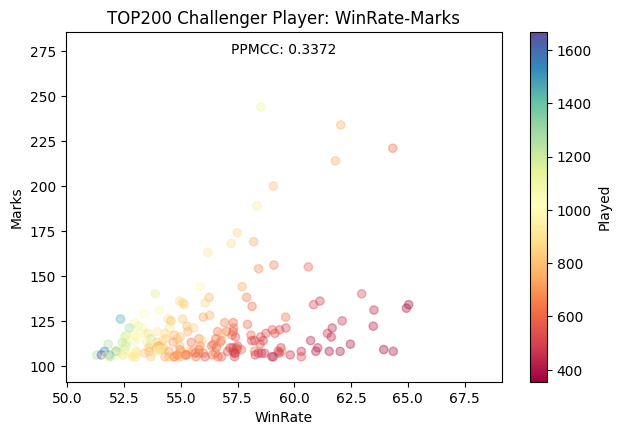

In [262]:
plot_3d_in_2d(x=df['WinRate'], 
              y=df['Marks'], 
              z=df['Played'],
              x_label='WinRate', y_label='Marks', z_label='Played',
              title='TOP200 Challenger Player: WinRate-Marks',
              save_name=file_name_pure+'(5).png')